# Agent design with Bayesian Network

## Importing libraries

In [2]:
!pip install pgmpy
import itertools
from mpl_toolkits import mplot3d
from matplotlib import cm
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination, BeliefPropagation

     |████████████████████████████████| 337kB 7.7MB/s 


## Utility methods

In [3]:
def exp_distrib(x, lambda_par):
  assert lambda_par > 0
  return lambda_par*np.exp(-lambda_par*x)

## Setting parameters

In [4]:
NUM_TEST_SENSORS = 40  # Number of time to draw sensors readings, used for plots
MAX_DIST = 10

diff = 0.6  # difficulty associated to target, 0-1
fail_def = 0.001  # Default prob of failure, 0-1
distances = [1.5, 2, 3]  # distances in metres
max_sense = 2 # Max distance for sensor, metres...at least 6 times bigger than s
lambda_sensors = 2
s = 0.5 # safe area around agent, metres

## Computes sensor probabilities from parameters

In [5]:
failure_sens = []
for i in range(len(distances)):
  measure = np.clip(distances[i], 0, max_sense)  # Sensors reading
  failure_sens.append(exp_distrib(measure-s, lambda_sensors) if measure > s else 1)  # Probability of collision for sensor i
  print("Probability of collision for sensor", i, ":", failure_sens[-1])

Probability of collision for sensor 0 : 0.2706705664732254
Probability of collision for sensor 1 : 0.09957413673572789
Probability of collision for sensor 2 : 0.09957413673572789


## Model

### Creating edges

In [6]:
edges = [('Fo', 'F'),
        ('Fd', 'F'),
        ('D', 'G'),
        ('F', 'G')]
for i in range(len(distances)):
  edges.append(('F'+str(i), 'Fo'))

### Creating model

In [7]:
agent_succ_model = BayesianModel(edges)

### Creating tables

#### Creating combinations and their probabilities

In [8]:
def create_combinations(n):
        """
        Creates all possible combinations of sensors 0..n-1.
        @:return List of tuples, where each tuple has a list (combination of sensors) and the probability associated
        """
        combs = []
        goals = list(range(n))
        for i in range(1, n+1):
            combs += ([(x, len(x)*0.95/n)for x in itertools.combinations(goals, i)])
        return combs

In [9]:
# Constant tables (no sensor)
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[1-diff], [diff]])  # Target difficulty
cpd_fd = TabularCPD(variable='Fd', variable_card=2, values=[[1-fail_def], [fail_def]])  # Default Failure
cpd_f = TabularCPD(variable='F', variable_card=2, values=[[1, 0, 0.01, 0],  # Total Failure
                                                          [0, 1, 0.99, 1]],
                   evidence=['Fo', 'Fd'],
                   evidence_card=[2, 2])
cpd_go = TabularCPD(variable='G', variable_card=2,  # Goal or Stop
                        values=[[0.0, 1.0, 0.5, 1.0],
                                [1.0, 0.0, 0.5, 0.0]],
                        evidence=['D', 'F'],
                        evidence_card=[2, 2])
cpds = [cpd_d, cpd_fd, cpd_f, cpd_go]

# Tables associated to sensors
for i in range(len(distances)):
  cpds.append(TabularCPD(variable='F'+str(i), variable_card=2, values=[[1-failure_sens[i]], [failure_sens[i]]]))

# Creating obstacle failure from sensors failures
false_probs = [1]  # All sensors free
combs_prob = create_combinations(len(distances))  # Noisy-OR
for comb in combs_prob:
  false_probs.append(1-comb[1])
cpd_fo = TabularCPD(variable='Fo', variable_card=2, values=[false_probs,   # Obstacle Failure
                                                            [1-x for x in false_probs]],
                    evidence=['F'+str(i) for i in range(len(distances))],
                    evidence_card=[2 for i in range(len(distances))])
cpds.append(cpd_fo)

### Adding tables to model and checking if they are valid

In [10]:
for cpd in cpds:
  agent_succ_model.add_cpds(cpd)

if agent_succ_model.check_model():
  print("Cpds and model valid.")
else:
  print("Cpds and model not valid.")

Cpds and model valid.


### Showing cpds

In [11]:
for i in range(len(distances)):
    print("Cpd for Failure Obstacle ", str(i), "\n", agent_succ_model.get_cpds('F'+str(i)))
print("Cpd for Difficulty\n", agent_succ_model.get_cpds('D'))
print("Cpd for Default Failure\n", agent_succ_model.get_cpds('Fd'))
print("Cpd for Obstacles Failure\n", agent_succ_model.get_cpds('Fo'))
print("Cpd for Total Failure\n", agent_succ_model.get_cpds('F'))
print("Cpd for Stop\n", agent_succ_model.get_cpds('G'))

Cpd for Failure Obstacle  0 
 +-------+----------+
| F0(0) | 0.729329 |
+-------+----------+
| F0(1) | 0.270671 |
+-------+----------+
Cpd for Failure Obstacle  1 
 +-------+-----------+
| F1(0) | 0.900426  |
+-------+-----------+
| F1(1) | 0.0995741 |
+-------+-----------+
Cpd for Failure Obstacle  2 
 +-------+-----------+
| F2(0) | 0.900426  |
+-------+-----------+
| F2(1) | 0.0995741 |
+-------+-----------+
Cpd for Difficulty
 +------+-----+
| D(0) | 0.4 |
+------+-----+
| D(1) | 0.6 |
+------+-----+
Cpd for Default Failure
 +-------+-------+
| Fd(0) | 0.999 |
+-------+-------+
| Fd(1) | 0.001 |
+-------+-------+
Cpd for Obstacles Failure
 +-------+-------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+----------------------+
| F0    | F0(0) | F0(0)               | F0(0)               | F0(0)               | F0(1)              | F0(1)              | F0(1)              | F0(1)                |
+-------

## Performing inference

### Variable Elimination

In [12]:
agent_succ_infer = VariableElimination(agent_succ_model)

### Testing times

In [13]:
# Computing the probability of stop.
q = agent_succ_infer.query(variables=['G'], show_progress=False)
print("Probability of stop\n", q, "\n")

# Probability of failure obstacles given stop.
q = agent_succ_infer.query(variables=['Fo'], evidence={'G': 1}, show_progress=False)
print("Probability of failure obstacles given G: 1\n", q, "\n")

# Probability of failure obstacles given stop and difficulty.
q = agent_succ_infer.query(variables=['Fo'], evidence={'G': 1, 'D': 1}, show_progress=False)
print("Probability of failure obstacles given G: 1 and D:1\n", q, "\n")

# Probability of stop given failure obstacles.
q = agent_succ_infer.query(variables=['G'], evidence={'Fo': 1}, show_progress=False)
print("Probability of stop given Fo: 1\n", q, "\n")

# Computing the joint probability of failure obstacles and difficulty given G: 0
q = agent_succ_infer.query(variables=['Fo', 'D'], evidence={'G': 0}, show_progress=False)
print("Joint Probability of failure obstacles and difficulty given G: 0\n", q, "\n")

Probability of stop
 +------+----------+
| G    |   phi(G) |
+======+==========+
| G(0) |   0.4502 |
+------+----------+
| G(1) |   0.5498 |
+------+----------+ 

Probability of failure obstacles given G: 1
 +-------+-----------+
| Fo    |   phi(Fo) |
+=======+===========+
| Fo(0) |    0.9973 |
+-------+-----------+
| Fo(1) |    0.0027 |
+-------+-----------+ 

Probability of failure obstacles given G: 1 and D:1
 +-------+-----------+
| Fo    |   phi(Fo) |
+=======+===========+
| Fo(0) |    0.9973 |
+-------+-----------+
| Fo(1) |    0.0027 |
+-------+-----------+ 

Probability of stop given Fo: 1
 +------+----------+
| G    |   phi(G) |
+======+==========+
| G(0) |   0.9930 |
+------+----------+
| G(1) |   0.0070 |
+------+----------+ 

Joint Probability of failure obstacles and difficulty given G: 0
 +------+-------+-------------+
| D    | Fo    |   phi(D,Fo) |
+======+=======+=============+
| D(0) | Fo(0) |      0.0007 |
+------+-------+-------------+
| D(0) | Fo(1) |      0.1900 |


## Plots

In [14]:
def all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=False):
    agent_succ_model = BayesianModel(edges)
    failure_sens = []
    for i in range(len(distances)):
        measure = np.clip(distances[i], 0, max_sense)
        failure_sens.append(exp_distrib(measure-s, lambda_sensors) if measure > s else 1)
    # Constant tables (no sensor)
    cpd_d = TabularCPD(variable='D', variable_card=2, values=[[1-diff], [diff]])  # Target difficulty
    cpd_fd = TabularCPD(variable='Fd', variable_card=2, values=[[1-fail_def], [fail_def]])  # Default Failure
    cpd_f = TabularCPD(variable='F', variable_card=2, values=[[1, 0, 0.01, 0],  # Total Failure
                                                              [0, 1, 0.99, 1]],
                       evidence=['Fo', 'Fd'],
                       evidence_card=[2, 2])
    cpd_go = TabularCPD(variable='G', variable_card=2,  # Goal or Stop
                            values=[[0.0, 1.0, 0.5, 1.0],
                                    [1.0, 0.0, 0.5, 0.0]],
                            evidence=['D', 'F'],
                            evidence_card=[2, 2])
    cpds = [cpd_d, cpd_fd, cpd_f, cpd_go]

    # Tables associated to sensors
    for i in range(len(distances)):
        cpds.append(TabularCPD(variable='F'+str(i), variable_card=2, values=[[1-failure_sens[i]], [failure_sens[i]]]))

    # Creating obstacle failure from sensors failures
    false_probs = [1]  # All sensors free
    combs_prob = create_combinations(len(distances))  # Noisy-OR
    for comb in combs_prob:
        false_probs.append(1-comb[1])
    cpd_fo = TabularCPD(variable='Fo', variable_card=2, values=[false_probs,   # Obstacle Failure
                                                                [1-x for x in false_probs]],
                        evidence=['F'+str(i) for i in range(len(distances))],
                        evidence_card=[2 for i in range(len(distances))])
    cpds.append(cpd_fo)
    for cpd in cpds:
        agent_succ_model.add_cpds(cpd)
        
    bp = BeliefPropagation(agent_succ_model)
    bp.calibrate()
    
    if not return_both:
        return None, bp
    
    return VariableElimination(agent_succ_model), bp

### Diff vs Goal

In [15]:
fail_def = 0.001
max_sense = 3
s = 0.5

diff_values = [float(diff)/100 for diff in range(0, 105, 5)]
goals = []
for diff in diff_values:
    tmp_mean = 0
    for i in range(NUM_TEST_SENSORS):
        distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
        _, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s)
        q = bp.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / NUM_TEST_SENSORS)

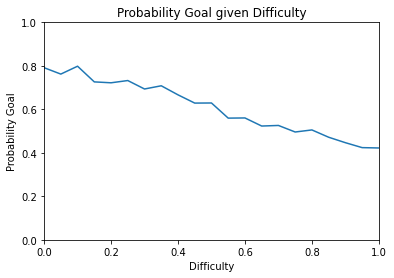

In [16]:
plt.plot(diff_values, goals)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Probability Goal given Difficulty")
plt.xlabel("Difficulty")
plt.ylabel("Probability Goal")
plt.show()

### Fail def vs Goal

In [17]:
max_sense = 3
s = 0.5

fail_def_values = [float(fail_def)/100 for fail_def in range(0, 105, 5)]
goals = []
for fail_def in fail_def_values:
    tmp_mean = 0
    for i in range(NUM_TEST_SENSORS):
        distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
        diff = random.random()
        _, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s)
        q = bp.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / NUM_TEST_SENSORS)

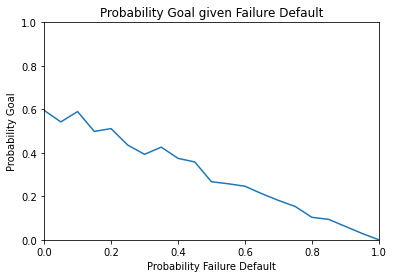

In [18]:
plt.plot(fail_def_values, goals)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Probability Goal given Failure Default")
plt.xlabel("Probability Failure Default")
plt.ylabel("Probability Goal")
plt.show()

### Max sense vs Goal

In [19]:
fail_def = 0.001
s = 0.5

max_sense_values = [max_sense for max_sense in range(0, 9)]
goals = []
for max_sense in max_sense_values:
    tmp_mean = 0
    for i in range(NUM_TEST_SENSORS):
        distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
        diff = random.random()
        _, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s)
        q = bp.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / NUM_TEST_SENSORS)

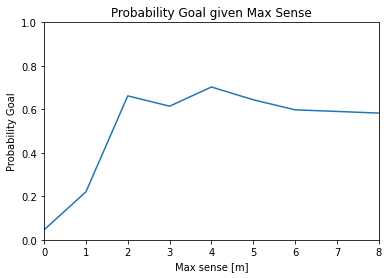

In [20]:
plt.plot(max_sense_values, goals)
plt.xlim([max_sense_values[0], max_sense_values[-1]])
plt.ylim([0, 1])
plt.title("Probability Goal given Max Sense")
plt.xlabel("Max sense [m]")
plt.ylabel("Probability Goal")
plt.show()

### S vs Goal with max sense to 3

In [21]:
fail_def = 0.001
max_sense = 3
min_s = 1
max_s = 10

s_values = [s/2 for s in range(min_s, max_s+1)]
goals = []
for s in s_values:
    tmp_mean = 0
    for i in range(NUM_TEST_SENSORS):
        distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
        diff = random.random()
        _, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s)
        q = bp.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / NUM_TEST_SENSORS)

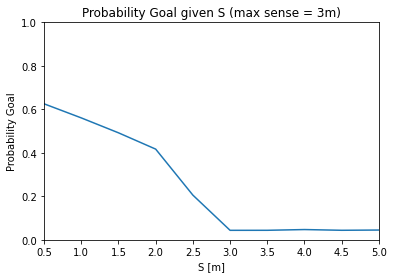

In [22]:
plt.plot(s_values, goals)
plt.xlim([min_s/2, max_s/2])
plt.ylim([0, 1])
plt.title("Probability Goal given S (max sense = 3m)")
plt.xlabel("S [m]")
plt.ylabel("Probability Goal")
plt.show()

### S and Max sense vs Goal

In [23]:
fail_def = 0.01

tmp_s = []
tmp_def = []
max_sense_values = [max_sense for max_sense in range(1, 9)]
s_values = np.linspace(0, 3, 12)
goals = []
for s in s_values:
  goals.append([])
  for max_sense in max_sense_values:
    tmp_mean = 0
    for i in range(NUM_TEST_SENSORS):
      distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
      diff = random.random()
      _, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s)
      q = bp.query(variables=['G'], show_progress=False)
      tmp_mean += q.values[1]
    goals[-1].append(tmp_mean / NUM_TEST_SENSORS)

In [24]:
X, Y = np.meshgrid(max_sense_values, s_values)

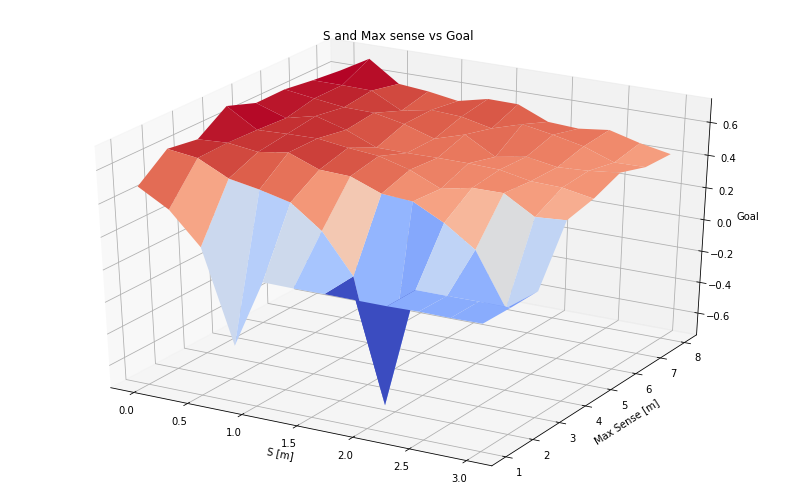

In [25]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection='3d')

ax.plot_surface(Y, X, np.array(goals), cmap=cm.coolwarm, edgecolor='none')
ax.set_title('S and Max sense vs Goal')
ax.set_ylabel("Max Sense [m]")
ax.set_xlabel("S [m]")
ax.set_zlabel("Goal")
plt.show()

### Difficulty and Max sense vs Goal

In [26]:
fail_def = 0.01
s = 0.5

max_sense_values = [max_sense for max_sense in range(1, 9)]
diff_values = np.linspace(0, 1, 20)
goals = []
for diff in diff_values:
  goals.append([])
  for max_sense in max_sense_values:
    tmp_mean = 0
    for i in range(NUM_TEST_SENSORS):
      distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
      _, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s)
      q = bp.query(variables=['G'], show_progress=False)
      tmp_mean += q.values[1]
    goals[-1].append(tmp_mean / NUM_TEST_SENSORS)
X, Y = np.meshgrid(max_sense_values, diff_values)

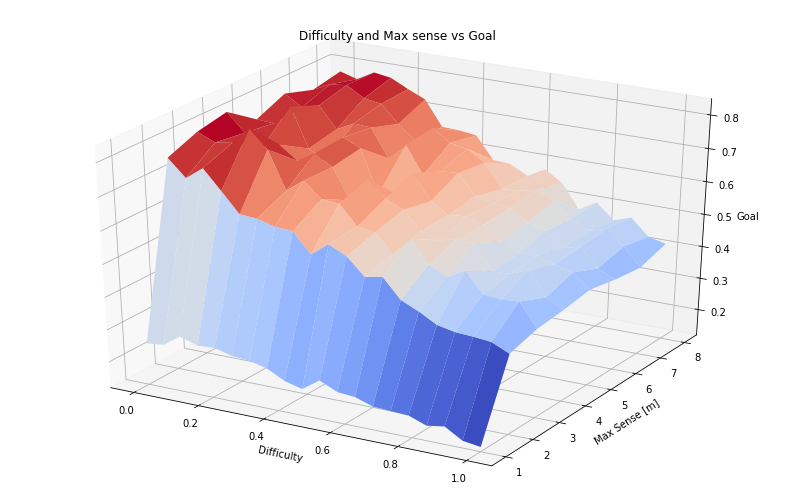

In [27]:
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection='3d')

ax.plot_surface(Y, X, np.array(goals), cmap=cm.coolwarm, edgecolor='none')
ax.set_title('Difficulty and Max sense vs Goal')
ax.set_xlabel("Difficulty")
ax.set_ylabel("Max Sense [m]")
ax.set_zlabel("Goal")
plt.show()

## Testing Belief Propagation and Variable Elimination

Gathering results for speed when using different methods for inference.

In [36]:
diff = 0.6
fail_def = 0.001
max_sense = 3
s = 0.5

times_ve = []
times_bp = []

# Case 1: No evidence
avg_ve = 0.0
avg_bp = 0.0
for i in range(NUM_TEST_SENSORS):
    distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
    agent_succ_infer, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=True)
    
    st_time = time.time()
    _ = agent_succ_infer.query(variables=['G'], show_progress=False)  # VA
    avg_ve += time.time()-st_time
    
    st_time = time.time()
    _ = bp.query(variables=['G'], show_progress=False)  #BP
    avg_bp += time.time()-st_time
    
times_ve.append(avg_ve / NUM_TEST_SENSORS)
times_bp.append(avg_bp / NUM_TEST_SENSORS)

# Case 2: Difficulty as evidence
avg_ve = 0.0
avg_bp = 0.0
for i in range(NUM_TEST_SENSORS):
    distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
    agent_succ_infer, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=True)
    
    st_time = time.time()
    _ = agent_succ_infer.query(variables=['G'], evidence={'D': 1}, show_progress=False)  # VA
    avg_ve += time.time()-st_time
    
    st_time = time.time()
    _ = bp.query(variables=['G'], evidence={'D': 1}, show_progress=False)  #BP
    avg_bp += time.time()-st_time
    
times_ve.append(avg_ve / NUM_TEST_SENSORS)
times_bp.append(avg_bp / NUM_TEST_SENSORS)

# Case 3: Failure Obstacle as evidence
avg_ve = 0.0
avg_bp = 0.0
for i in range(NUM_TEST_SENSORS):
    distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
    agent_succ_infer, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=True)
    
    st_time = time.time()
    _ = agent_succ_infer.query(variables=['G'], evidence={'Fo': 1}, show_progress=False)  # VA
    avg_ve += time.time()-st_time
    
    st_time = time.time()
    _ = bp.query(variables=['G'], evidence={'Fo': 1}, show_progress=False)  #BP
    avg_bp += time.time()-st_time
    
times_ve.append(avg_ve / NUM_TEST_SENSORS)
times_bp.append(avg_bp / NUM_TEST_SENSORS)

# Case 4: Joint Failure Obstacle and Difficulty as evidence
avg_ve = 0.0
avg_bp = 0.0
for i in range(NUM_TEST_SENSORS):
    distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
    agent_succ_infer, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=True)
    
    st_time = time.time()
    _ = agent_succ_infer.query(variables=['G'], evidence={'Fo': 1, 'D': 0}, show_progress=False)  # VA
    avg_ve += time.time()-st_time
    
    st_time = time.time()
    _ = bp.query(variables=['G'], evidence={'Fo': 1, 'D': 0}, show_progress=False)  #BP
    avg_bp += time.time()-st_time
    
times_ve.append(avg_ve / NUM_TEST_SENSORS)
times_bp.append(avg_bp / NUM_TEST_SENSORS)

# Case 5: Difficulty as evidence
avg_ve = 0.0
avg_bp = 0.0
for i in range(NUM_TEST_SENSORS):
    distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
    agent_succ_infer, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=True)
    
    st_time = time.time()
    _ = agent_succ_infer.query(variables=['G'], evidence={'D': 0}, show_progress=False)  # VA
    avg_ve += time.time()-st_time
    
    st_time = time.time()
    _ = bp.query(variables=['G'], evidence={'D': 0}, show_progress=False)  #BP
    avg_bp += time.time()-st_time
    
times_ve.append(avg_ve / NUM_TEST_SENSORS)
times_bp.append(avg_bp / NUM_TEST_SENSORS)

# Case 6: Joint Goal, variable Failure Obstacle
avg_ve = 0.0
avg_bp = 0.0
for i in range(NUM_TEST_SENSORS):
    distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
    agent_succ_infer, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=True)
    
    st_time = time.time()
    _ = agent_succ_infer.query(variables=['Fo'], evidence={'G': 0}, show_progress=False)  # VA
    avg_ve += time.time()-st_time
    
    st_time = time.time()
    _ = bp.query(variables=['Fo'], evidence={'G': 0}, show_progress=False)  #BP
    avg_bp += time.time()-st_time
    
times_ve.append(avg_ve / NUM_TEST_SENSORS)
times_bp.append(avg_bp / NUM_TEST_SENSORS)

# Case 7: Joint Goal and Difficulty as evidence, variable Failure Obstacle
avg_ve = 0.0
avg_bp = 0.0
for i in range(NUM_TEST_SENSORS):
    distances = [random.random()*MAX_DIST, random.random()*MAX_DIST, random.random()*MAX_DIST]
    agent_succ_infer, bp = all_togheter(diff, fail_def, distances, lambda_sensors, max_sense, s, return_both=True)
    
    st_time = time.time()
    _ = agent_succ_infer.query(variables=['Fo'], evidence={'D': 1, 'G': 0}, show_progress=False)  # VA
    avg_ve += time.time()-st_time
    
    st_time = time.time()
    _ = bp.query(variables=['Fo'], evidence={'D': 1, 'G': 0}, show_progress=False)  #BP
    avg_bp += time.time()-st_time
    
times_ve.append(avg_ve / NUM_TEST_SENSORS)
times_bp.append(avg_bp / NUM_TEST_SENSORS)

Showing results

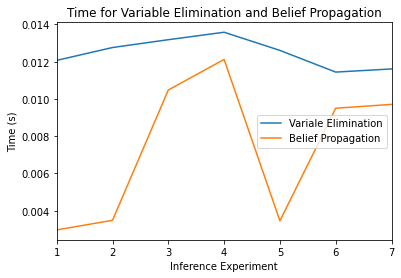

In [38]:
plt.plot(range(1, 8), times_ve, label="Variale Elimination")
plt.plot(range(1, 8), times_bp, label="Belief Propagation")
plt.xlim([1, 7])
plt.title("Time for Variable Elimination and Belief Propagation")
plt.xlabel("Inference Experiment")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

In [39]:
print("Average time for Variable elimination: ", np.mean(times_ve))
print("Average time for Belief Propagation: ", np.mean(times_bp))

Average time for Variable elimination:  0.012467351130076817
Average time for Belief Propagation:  0.00738992520741054
